# Similarity for a Single Clothing Class

Goal: Pull clothes from a single class (e.g. Blouse), and return similar ones.

In [3]:
import numpy as np

%load_ext autoreload
%autoreload 2

from src.fashion_tools import DeepFashion, cloth_category, generate_features, image_to_feature

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#cloth_category("labels/list_category_cloth.txt")

In [4]:
deepDict = DeepFashion("Top")

In [5]:
#compute feautres for for all items in the clothing category
from keras.models import load_model
encoder = load_model("models/encoder_model_current.h5")
encoder.load_weights("models/encoder_model_weights_current.h5")
decoder = load_model("models/decoder_model_current.h5")
decoder.load_weights("models/decoder_model_weights_current.h5")

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
fullpath_to_data = "/home/dawnis/Data/SmartMirror/DeepFashion_Data"

In [6]:
#image_to_feature("/".join([fullpath_to_data, "img/Boxy_Open_Mesh_Top/img_00000050.jpg"]), deepDict["img/Boxy_Open_Mesh_Top/img_00000050.jpg"], encoder)

In [22]:
#clothing_feature_vectors = generate_features(deepDict, fullpath_to_data, encoder)
clothing_feature_vectors = [image_to_feature("/".join([fullpath_to_data, imagepath]), boundingBox, encoder, "All") for imagepath, boundingBox in deepDict.items()]
fv = np.array(clothing_feature_vectors)                  

np.save("features/current_feature_vector.npy", fv)

In [7]:
clothing_feature_vectors_ae = [image_to_feature_ae("/".join([fullpath_to_data, imagepath]), boundingBox, encoder) for imagepath, boundingBox in deepDict.items()]
fv_ae = np.array(clothing_feature_vectors_ae)   

np.save("models/current_feature_vector_ae.npy", fv_ae)

clothing_feature_vectors_hog = [image_to_feature_hog("/".join([fullpath_to_data, imagepath]), boundingBox, encoder) for imagepath, boundingBox in deepDict.items()]
fv_hog = np.array(clothing_feature_vectors_hog)   

np.save("models/current_feature_vector_hog.npy", fv_hog)


In [9]:
fv_ae.shape

(10078, 512)

# choose an image at random and then return the top 5 similar ones from deepDict`

In [2]:
from src.fashion_tools import fashion_similarity
import numpy as np

%load_ext autoreload
%autoreload 2

from src.fashion_tools import DeepFashion, cloth_category, generate_features, image_to_feature, rgb_image_bounding_box
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [4]:
#fv = np.load('features/current_feature_vector.npy')
fv = np.load('features/current_feature_vector_hsv.npy')
#fv = np.load('models/current_feature_vector_hog.npy')
#fv = np.load('models/current_feature_vector_ae.npy')

print(fv.shape)
deepDict = DeepFashion("Top")

fullpath_to_data = "/home/dawnis/Data/SmartMirror/DeepFashion_Data"

deepKeys = [keyname for keyname in deepDict.keys()]

(10078, 18)


In [35]:
fv[0][255]

0.8972067126105967

In [3]:
from sklearn.decomposition import PCA as pca
cloth_dimension = pca(n_components=2)
cloth_pca = cloth_dimension.fit(fv.transpose())

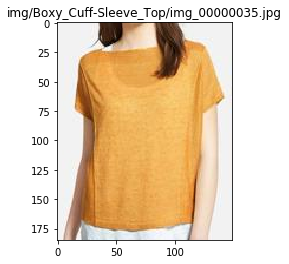

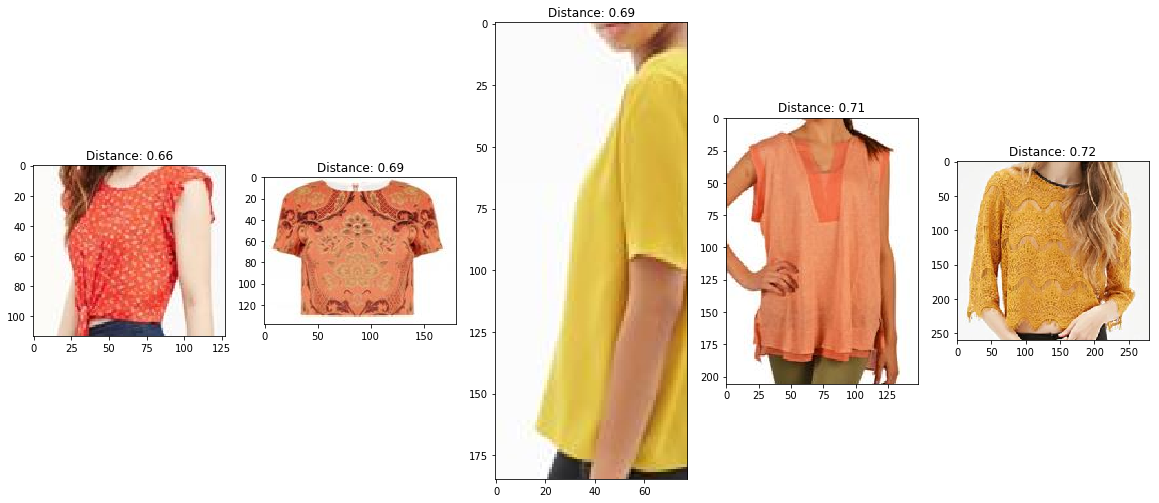

In [30]:
choice = np.random.choice(deepKeys, size=1)[0]

f, ax = plt.subplots()
image = rgb_image_bounding_box("/".join([fullpath_to_data, choice]), deepDict[choice], convert_bgr=True)
ax.imshow(image)
ax.set_title("{}".format(choice))
#cv2.imwrite("key.png", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
cv2.imwrite("key.png", image)

similarity_scores = fashion_similarity(choice, fv, deepKeys)
similarity_scores[deepKeys.index(choice)] = np.max(similarity_scores)
closest = np.argsort(np.array(similarity_scores))
#closest[deepKeys.index(choice)] = np.max(closest)
f2, az = plt.subplots(1,5)
f2.set_figheight(10)
f2.set_figwidth(20)


for idx, match in enumerate( closest[1:6]):
    keyname = deepKeys[match]
    image = rgb_image_bounding_box("/".join([fullpath_to_data, keyname]), deepDict[keyname], convert_bgr=True)
    az[idx].imshow(image)
    az[idx].set_title("Distance: {:.2f}".format(similarity_scores[match]))
    #cv2.imwrite("match_{:02d}.png".format(idx), cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    cv2.imwrite("match_{:02d}.png".format(idx), image)

In [ ]:
f, ax = plt.subplots(1, 2)
f.set_figwidth(20)

distances, bins = np.histogram(similarity_scores, bins=20)
ax[0].bar(bins[1:], distances, width=5)
ax[0].set_xlabel("Similarity Distance")
ax[0].set_ylabel("Count")
ax[0].set_title("Histogram")

ax[1].scatter(cloth_pca.components_[0], cloth_pca.components_[1])
for idx, match in enumerate( closest[1:6]):
    ax[1].plot(cloth_pca.components_[0,match], cloth_pca.components_[1,match], 'ro')
ax[1].set_title("pca distance")

# notes
seems to be picking up similarity in shape and human pose when both are used together

what is the difference between the HOG and AE features?

1.) hog is contributing to shape matching well
2.) ae seems to have more stylistic info...maybe shape??? seems to have some color information

ae failures:
Boxy_Denim_Crop_Top_54
Abstract_Chevron_Print_Top_010

can't detect stripes or other fine features
seems to be 

HOG failures
Always_be_chic_top_52..complete failure, don't know why
very sensitive to the pose of the person in the image

How to know??

reduce dimensionality and visualize feature vectors in 2D

# Notes from Faraz
t-sne is computationally intensive, he worked with 5000 samples and a dimensionality of 20

do you have labels to prove that this is working? (e.g. scrape from pinterest and show that grouped images have lower distance to each other than non-grouped images, or polyvore)

how can you validate??

says what he didn't expect was the amount of time learning new stuff all the time. like research